Connected to Python 3.9.6

In [1]:
"""
Competitive Lotka-Volterra Model of cell growth

NOTE: OptModel() contains a method to numerically fit equilibrium values given enough time in an ODE solver. This file contains a different method FitInTime() that is used to fit timed experimental data and is designed to be used with scipy.optimize.minimize() as it returns a sum of squares rather than providing its own parameter-optimization method.

List of functions:
    - LVnprime(): Returns derivative of population vector for a competitive Lotka-Voltera model
    - FitInTime(): Given parameters, evaluates a system of ODEs across a period of interest and returns loss (including penalty functions)
    - do_CLVOpt(): Performs the optimization routine for a control-type CHData point 
    - do_treat_CLVOpt(): do_CLVOpt() for non-control data, incorporating multiphase experimental model and multiple parameter sets
    - find_neighbors(): for a non-control data point, explores control data to establish strict optimization constraints for parameters
    - getstat_CLVOpt(): given a dict of CHData, performs optimization routine on each one, compiles parameter information, and returns information about the distribution of parameters
"""

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from OptModel import *
from parsedata import *
from scipy.optimize import minimize
import time

ktot = 30000
def LVnprime(y, t, r, Amat):
    """
    Returns the derivative at a time-step for the competitive Lotka-Volterra model with carrying capacity ktot defined outside of the function.
    """
    vlen = len(r)
    dN = list(r*y*(np.ones(vlen)-np.matmul(Amat,y)/ktot))
    return dN

def FitInTime(params, dfunc, chdata, interaction_const=np.inf, samplingrate=1000):
    """
    Solves an ODE given parameters and then evaluates the results against time-associated data, returning a sum of squares. 
    Args:   
            params: 1D array of parameters to be fit. Must be flattened list of rvec and then Amat in the standard order [WT, TP53, Tet2].
            dfunc: ODE to be evaluated
            data: CHData object that contains what data should be fitted.
            samplingrate: how many points (per week) the function should use in ODE solving
            interaction_const: value for constraints on interactions which will take the form (-interaction_const, +interaction_const)
    Returns: Sum of squared errors from the data.
    """
    if type(chdata) != type(CHData("foo")):
        raise Exception("FitInTime() currently requires data passed in as the CHData class.")
    
    if len(params) != 9:
        raise Exception("9 parameters must be passed into the function as a 1D list.")
    else:
        rvec = np.array(params[:3])
        aprog = np.array(params[3:])
        for i in range(len(rvec)):
            aprog = np.insert(aprog, 4*i, 1)
        amat = aprog.reshape((3,3))
    
    if "2X" in chdata.type:
        ics = [400, 50, 50]
    elif "Tet2" in chdata.type:
        ics = [450, 0, 50]
    elif "TP53" in chdata.type:
        ics = [450, 50, 0]
    
    soln = odeint(dfunc, ics, np.linspace(0, 14, 14*samplingrate), args=(rvec, amat))
    
    totloss = 0
    for profile in chdata.data:
        nsoln = soln[samplingrate*(profile.week)-1]
        psoln = nsoln/(sum(nsoln))
        ptarget = [i/100 for i in profile.probs]
        lvect = (ptarget - psoln)**2
        pointloss = sum(lvect)
        totloss += pointloss
    
    # Penalty function for constrained optimization
    # growth rates cannot be less than zero or greater than two (see [1], pg. 38 where this is the truncated range of birthrates; also [2]); we use (always positive) ramp functions on either side of an acceptable range to create a "well" in which rates can exist without penalty
    penalty = 0
    for rate in rvec:
        penalty += max(abs(min(rate, 0)),abs(max(rate-2,0)))

    if interaction_const != np.inf:
        for aij in aprog:
            penalty += max(abs(min(rate+interaction_const, 0)),abs(max(rate-interaction_const,0)))

    return totloss + penalty

def do_CLVopt(chdata, verbose=True, savefig=False, savepath="plots", getloss=False, **kwargs):
    """
    Runs the optimization routine for the specified datapoint. 
    Args:   
            chdata: the datapoint specified, must be CHData
            verbose: if true, will print runtime and plot data/model in addition to returning the parameters
            savefig: if true, will save the plots generated if verbose is set to true
            savepath: allows user to specify where to save plots
            getloss: bool that if set to true will have the function return the loss in adition to parameters
    Accepted kwargs:
            interaction_const: optional argument to be passed to FitInTime()
    Returns: A list of parameters (rate vector and interaction matrix), with the loss appended if getloss is set to true
    """
        
    start = time.time()        
    guess0 = np.concatenate((np.ones(3).reshape(1,3), np.zeros((2,3)))).flatten()
    base_args = (LVnprime, chdata)
    if "interaction_const" in kwargs:
        pass_args = base_args + (kwargs.get("interaction_const"),)
    else:
        pass_args = base_args

    minobj = minimize(FitInTime, guess0, args=pass_args, method="Nelder-Mead", options={"maxiter":5000, "disp":False, "xatol":5e-6, "fatol":5e-6})
    end = time.time()

    optparams = minobj["x"]
    print(optparams)
    optr = optparams[:3]
    optAprog = optparams[3:]
    for i in range(3):
        optAprog = np.insert(optAprog, 4*i, 1)
    print(optAprog)
    optA = optAprog.reshape((3,3))
    
    if verbose:
        print("Optimization took {} seconds.".format(end-start))
        
        if "2X" in chdata.type:
            ics = [400, 50, 50]
        elif "Tet2" in chdata.type:
            ics = [450, 0, 50]
        elif "TP53" in chdata.type:
            ics = [450, 50, 0]

        times = np.linspace(0,20,20000)
        soln = odeint(LVnprime, ics, times, args=(optr, optA))
        
        fig = plt.figure(num=1, clear=True)
        ax = fig.add_subplot(1,1,1)
        ax.plot(times, soln[:,0], 'b-', label="WT")
        ax.plot(times, soln[:,1], 'g-', label="TP53")
        ax.plot(times, soln[:,2], 'k-', label="Tet2")
        ax.set(ylabel="population size", xlabel="time (weeks)", title="Population trajectories for model {}".format(chdata.name))
        for profile in chdata.data:
            colororder = ['bo', 'go', 'ko']
            for i in range(3):
                ax.plot(profile.week, profile.probs[i]/100*sum(soln[1000*profile.week-1]), colororder[i])
        ax.legend()
        fig.show()

        if savefig:
            fig.savefig("{dir}/{ID}.png".format(dir=savepath, ID=chdata.name))

        print("Model ", chdata.name)
        print("---")
        print("The loss for this model is ", minobj["fun"])
        print("Rate vector is: ", optr)
        print("Interaction matrix is: ", optA)

    returnlist = [optr, optA]

    if getloss:
        returnlist.append(minobj["fun"])

    return returnlist

def do_treat_CLVopt(chdata, verbose=True, savefig=False, savepath="plots", getloss=False, samplingrate=1000, neg_rate=False, **kwargs):
    """
    Equivalent function to do_CLVOpt() for treatment data incorporating the find_neighbors routine and a two-phase CLV model.

    This function can also optionally take in a dictionary containing control data, which allows constraint identification for the first phase of the CLV model (nontreatment). If no control dictionary is passed (or a pair of neighbors is not identified), then the routine allows the entire search area to be permitted. Interaction constraints can still be set in the same manner as the do_CLVopt function. shortloss() and longloss() are written as inner functions here, 
    
    Args:   
            chdata: the datapoint specified, must be CHData
            verbose: if true, will print runtime and plot data/model in addition to returning the parameters
            savefig: if true, will save the plots generated if verbose is set to true
            savepath: allows user to specify where to save plots
            getloss: bool that if set to true will have the function return the loss in adition to parameters
            samplingrate: how many points (per week) the function should use in ODE solving
            neg_rate: if true, will allow rates from [-2, 2] instead of [0, 2]
    Accepted kwargs:
            controldict: optional dictionary of control-type data to be used in a find_neighbors call
            interaction_const: optional argument to be passed to FitInTime()
    Returns: A list of parameters (rate vector and interaction matrix), with the loss appended if getloss is set to true
    """
    if "controldict" in kwargs:
        cdict = kwargs.get("controldict")
        bounds = find_neighbors(chdata, cdict)
        constraints = []
        if bounds[0] == bounds[1]:
            print("No pair of neighbors identified; no constraints will be assigned.")
            constraints = False
            # Also might want to throw a warning here
        else:
            pt1 = cdict[bounds[0]]
            pt2 = cdict[bounds[1]]
            if pt1.opt != True:
                pt1.optimize()
            if pt2.opt != True:
                pt2.optimize()
            for i in range(3):
                constraints.append([pt1.rates[i],pt2.rates[i]])
            for i in range(3):
                for j in range(3):
                    if i != j:
                        constraints.append([pt1.interactions[i,j], pt2.interactions[i,j]])
    
    # Assign initial conditions to be accessed by inner functions
    if "2X" in chdata.type:
            ics = [400, 50, 50]
    elif "Tet2" in chdata.type:
            ics = [450, 0, 50]
    elif "TP53" in chdata.type:
            ics = [450, 50, 0]

    # inner function to pass into minimize, which incorporates the constraints. basically the same as FitInTime() but for only up to wk. 5.
    def shortloss(params, dfunc, constlist=False, interaction_const=False):
        if len(params) != 9:
            raise Exception("9 parameters must be passed into the function as a 1D list.")
        else:
            rvec = np.array(params[:3])
            aprog = np.array(params[3:])
            for i in range(len(rvec)):
                aprog = np.insert(aprog, 4*i, 1)
            amat = aprog.reshape((3,3))
        
        soln = odeint(dfunc, ics, np.linspace(0, 5, 5*samplingrate), args=(rvec, amat))
        nsoln = soln[samplingrate*(5)-1]
        lvect = ([i/100 for i in chdata.data[0].probs] - nsoln/(sum(nsoln)))**2
        loss = sum(lvect)
        
        # Penalty function for constrained optimization. Constraints in control OVERRIDE interaction_const / other defaults.
        penalty = 0
        if constlist:
            for i in range(3):
                penalty += max(abs(min(rvec[i]-min(constlist[i]), 0)),abs(max(rvec[i]-max(constlist[i]),0)))
            # for i in range(6):
            #     penalty += max(abs(min(aprog[i]-min(constlist[i+3]), 0)),abs(max(aprog[i]-max(constlist[i+3]),0)))
        elif interaction_const:
            for i in range(3):
                penalty += max(abs(min(rvec[i], 0)),abs(max(rvec[i]-2,0)))
            for i in range(6):
                penalty += max(abs(min(rvec[i]+interaction_const, 0)),abs(max(rvec[i]-interaction_const,0)))

        # Constraint penalty function
        return loss+penalty
    
    args = (LVnprime, constraints)
    if "interaction_const" in kwargs:
        args = args + (kwargs.get("interaction_const"))

    guess0 = np.concatenate((np.ones(3).reshape(1,3), np.zeros((2,3)))).flatten()
    startminobj = minimize(shortloss, guess0, args=args, method="Nelder-Mead", options={"maxiter":5000, "disp":False, "xatol":5e-6, "fatol":5e-6})

    rvec1 = np.array(startminobj['x'][:3])
    aprog1 = np.array(startminobj['x'][3:12])
    for i in range(len(rvec1)):
        aprog1 = np.insert(aprog1, 4*i, 1)
    amat1 = aprog1.reshape((3,3))

    returnlist = [rvec1, amat1]
    if getloss:
        returnlist.append(startminobj['fun'])
    ics2 = odeint(LVnprime, ics, np.linspace(0, 5, 5*samplingrate), args=(rvec1, amat1))[samplingrate*(5)-1]

    # Now that the initial parameters have been optimized, proceed with minimization using TreatFitInTime()... tbw. Rn returns parameters to test.
    # another inner function to minimize
    def longloss(params, dfunc, interaction_const=False):
        if len(params) != 9:
            raise Exception("9 parameters must be passed into the function as a 1D list.")
        else:
            rvec = np.array(params[:3])
            aprog = np.array(params[3:])
            for i in range(len(rvec)):
                aprog = np.insert(aprog, 4*i, 1)
            amat = aprog.reshape((3,3))

        soln = odeint(dfunc, ics2, np.linspace(6, 14, 14*samplingrate), args=(rvec, amat))
        
        totloss = 0
        for profile in chdata.data[1:]: # Exclude up to week 6
            nsoln = soln[samplingrate*(profile.week-6)-1] # week 6 --> apparent week 0
            psoln = nsoln/(sum(nsoln))
            ptarget = [i/100 for i in profile.probs]
            lvect = (ptarget - psoln)**2
            pointloss = sum(lvect)
            totloss += pointloss
        
        penalty = 0
        for rate in rvec:
            penalty += max(abs(min(rate+2*neg_rate, 0)),abs(max(rate-2,0))) # In this phase we allow cells to have negative death rate due to treatment if neg_rate is enabled

        if interaction_const:
            for aij in aprog:
                penalty += max(abs(min(rate+interaction_const, 0)),abs(max(rate-interaction_const,0)))

        return totloss + penalty
    
    midminobj = minimize(longloss, startminobj['x'], args=(LVnprime,), method="Nelder-Mead", options={"maxiter":5000, "disp":False, "xatol":5e-6, "fatol":5e-6})

    rvec2 = np.array(midminobj['x'][:3])
    aprog2 = np.array(midminobj['x'][3:12])
    for i in range(len(rvec2)):
        aprog2 = np.insert(aprog2, 4*i, 1)
    amat2 = aprog2.reshape((3,3))

    returnlist.append(rvec2)
    returnlist.append(amat2)
    if getloss:
        returnlist.append(midminobj['fun'])

    return returnlist

def find_neighbors(chdata, controldict):
    """
    Helper function for treatment optimization (i.e. cisplatin). 
    
    Takes in a CHData and compares it to a reference dictionary containing fitted control CHData. NOTE: For now this function assumes Wk. 5 PB data is PRESENT and in the right format (i.e. we only compare 2X to 2X), or we raise an exception.

    Args:
        chdata: a CHData of non-control type
        controldict: a dictionary containing control CHData
    Returns: A list containing the two keys defining the minimal-area rectangle containing the specified CHData at wk 5.
    """
    for data in chdata.data:
        if data.week == 5:
            target = data.probs
            break
        else:
            target = False
    if not target:
        raise Exception("No week 5 data for comparison available in the specified CHData.")
    
    log = []
    for key in controldict.keys():
        thisdata = controldict[key]
        for data in thisdata.data:
            if data.week == 5:
                compare = data.probs
                break
            else:
                compare = False
        if not compare:
            print("Warning: CHData {} does not contain comparable data.".format(key))
            continue
        diff = [compare[i+1] - target[i+1] for i in range(len(compare)-1)] # Drop the first datapoint (WT), since for these values it is essentially dependent on the other population proportions (they must sum to 1)
        dist = np.linalg.norm(diff)
        log.append([dist, diff, key])
    
    log.sort(key=lambda x: x[0])

    start = 0
    end = len(log)
    vec1pos = 0
    vec2pos = False
    area = np.inf
    for i in range(end):
        base = np.array([obs for obs in log[i][1]])
        signs = np.sign(base)
        j = 0
        for compare in log[:i] + log[i+1:end]:
            compvals = np.array([obs for obs in compare[1]])
            compsigns = np.sign(compvals)
            if all(t == 0 for t in signs+compsigns):
                temparea = abs((base[0]-compvals[0])*(base[1]-compvals[1]))
                if temparea < area:
                    vec1pos = i
                    vec2pos = j + (j >= i)
                    area = temparea
                    end = j + (j >= i)
                break
            j += 1
        if i == end:
            break  

    if vec2pos == False:
        print("ERROR")
        pass

    keys = [log[vec1pos][-1],log[vec2pos][-1]]
    print("The minimal rectangle containing {} is given by {} and {}.".format(chdata.name, *keys))
    return keys

def getstat_CLVopt(datadict, illustrate=True, **kwargs):
    """
    Function that takes in a dictionary of CHData objects, runs the optimizer, and returns information about the parameter distribution of the fits. Always will also return information about stats.
    Args:
            datadict: the dictionary to be iterated over
            illustrate: boolean that determines whether or not to display a histogram of distributions and other statistical charts
    Accepted kwargs:
            interaction_const: interaction constraint for FitInTime
    Returns:
            a list of lists (as an np.array) [flattened parameter list, loss] for each data point passed in; the parameter list INCLUDES the diagonal ones, which the method will discard later
    """

    account = []
    for key in datadict.keys():
        result = do_CLVopt(datadict[key], verbose=False, getloss=True, **kwargs)
        paramarr = np.concatenate((result[0].reshape(1,3), result[1])).flatten()
        paramarr = np.append(paramarr, result[2])
        account.append(paramarr)
    account = np.array(account)

    if illustrate:
        n_bins = 20
        for i in range(len(account[0])-1):
            if i < 3:
                param = "r{}".format(i+1)
            else:
                param = "a{}{}".format((i-3)//3+1, (i-3)%3+1)
            
            # Histogram plot
            fig = plt.figure(num=1, clear=True)
            ax = fig.add_subplot(1,1,1)
            ax.hist(account[:,i], bins=n_bins)
            ax.set(xlabel="value", ylabel="number", title="Distribution of {}".format(param))
            fig.show()
            fig.savefig("plots/stats/rawhist_{}.jpg".format(param)) # .jpg because .png was not saving other info

            # Statistics

    return account


# Testing to make sure that methods work properly
if __name__=='__main__':
    testdict = {}
    sheet = r"C:\Users\tyler\Downloads\Tet2+TP53_summary.xlsx"
    readdata(sheet, testdict, "CW8_WBM")
    readdata(sheet, testdict, "CW6_BM")
    readdata(sheet, testdict, "CW6_PB")
    readdata(sheet, testdict, "CW8_PB")
    trialdata = [testdict["258a"], testdict["258b"], testdict["258c"], testdict["259a"],testdict["259c"],testdict["259d"]]
    
    # tottimestart = time.time()
    # for data in trialdata:
    #     do_CLVopt(data, savefig=False)
    # tottimeend = time.time()
    # print("In total took {t} seconds to evaluate {d} datapoints.".format(t=tottimeend-tottimestart, d=len(trialdata))) 

Making new CHData 337b
Making new CHData 337c
Making new CHData 337d
Making new CHData 345a
Making new CHData 345b
Making new CHData 345c
Making new CHData 345d
Making new CHData 346b
Making new CHData 346c
Making new CHData 346d
Making new CHData 349c
Making new CHData 349d
Making new CHData 354a
Making new CHData 354b
Making new CHData 363a
Making new CHData 363b
Making new CHData 363c
Making new CHData 363d
Making new CHData 344a
Making new CHData 344b
Making new CHData 344c
Making new CHData 344d
Making new CHData 347b
Making new CHData 347c
Making new CHData 349b
Making new CHData 360a
Making new CHData 360b
Making new CHData 360c
Making new CHData 360d
Making new CHData 361a
Making new CHData 361b
Making new CHData 362b
Making new CHData 362c
Making new CHData 362d
Making new CHData 365a
Making new CHData 365b
Making new CHData 346a
Making new CHData 354c
Making new CHData 354d
Making new CHData 357a
Making new CHData 357b
Making new CHData 357c
Making new CHData 357d
Making new 

In [2]:
controldict = {}
for key in testdict.keys():
    if testdict[key].type.lower() != "2x":
        pass
    elif testdict[key].treatment.lower() != "control":
        pass
    elif len(testdict[key].data) != 3:
        pass
    else:
        controldict[key] = testdict[key]
        
treatdict = {}
for key in testdict.keys():
    if testdict[key].treatment.lower() == "control":
        pass
    elif testdict[key].type.lower() != "2x":
        pass
    elif len(testdict[key].data) == 3:
        treatdict[key] = testdict[key]

In [3]:
losstrackerSIX = []
for key in treatdict.keys():
    losstrackerSIX.append(do_treat_CLVopt(treatdict[key], controldict=controldict, getloss=True, neg_rate=False))

losstrackerSIXneg = []
for key in treatdict.keys():
    losstrackerSIXneg.append(do_treat_CLVopt(treatdict[key], controldict=controldict, getloss=True, neg_rate=True))    

The minimal rectangle containing 337b is given by 351b and 343b.
[ 3.92044282e-09  3.68603314e-02  1.62839975e-01  5.00892983e-03
  1.57292363e-02 -2.60019308e-03  1.29521979e-03 -1.43639758e-03
  2.81357619e-04]
[ 1.00000000e+00  5.00892983e-03  1.57292363e-02 -2.60019308e-03
  1.00000000e+00  1.29521979e-03 -1.43639758e-03  2.81357619e-04
  1.00000000e+00]
[ 1.95125225e-07  2.16506108e-02  1.01868179e-01  1.15930237e-02
 -7.78674846e-03  2.36048746e-03  5.63771369e-03  2.37614642e-03
  1.48215090e-03]
[ 1.          0.01159302 -0.00778675  0.00236049  1.          0.00563771
  0.00237615  0.00148215  1.        ]
The minimal rectangle containing 337c is given by 342d and 359b.
[ 4.14646896e-01  7.07158655e-11  2.15843762e-01  1.28393319e-03
 -3.76992140e-03  1.04628527e-02 -1.60103363e-03  3.13364280e-03
  2.36213057e-03]
[ 1.          0.00128393 -0.00376992  0.01046285  1.         -0.00160103
  0.00313364  0.00236213  1.        ]
[  0.40678928   0.24471574   0.38204675   6.99419918  15

c:\Users\tyler\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


The minimal rectangle containing 363b is given by 356a and 351c.
The minimal rectangle containing 363c is given by 356d and 359b.
[  0.35625392   0.34463153   0.27368129  12.44241394   6.92703978
   2.78223485  -2.47038037   1.28396795 -14.78796049]
[  1.          12.44241394   6.92703978   2.78223485   1.
  -2.47038037   1.28396795 -14.78796049   1.        ]
The minimal rectangle containing 363d is given by 364a and 364c.
[ 0.47571865  0.41746257  0.54951613 10.05180091 -1.91901689  0.89668269
 -0.15289009  2.65925325 -5.95065186]
[ 1.         10.05180091 -1.91901689  0.89668269  1.         -0.15289009
  2.65925325 -5.95065186  1.        ]
The minimal rectangle containing 344a is given by 352c and 340b.
[ 0.48920561  0.36199388  0.61546472 -2.46853074 -0.05005671  0.12510155
 -0.4135626   0.3890502   1.13704352]
[ 1.         -2.46853074 -0.05005671  0.12510155  1.         -0.4135626
  0.3890502   1.13704352  1.        ]
The minimal rectangle containing 344b is given by 351c and 356a.


(array([ 1.,  4.,  4.,  9.,  9., 10., 10., 10., 11., 12., 13., 14., 14.,
        20., 23., 25., 27., 28., 29., 32., 35., 36., 39., 40., 41., 43.,
        47., 49., 51., 54., 55., 58., 61., 63., 64., 65., 67., 68., 68.,
        68., 69., 69., 69., 69., 69., 71., 71., 72., 72., 72., 72., 73.,
        73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
        73., 73., 73., 73., 74., 74., 74., 74., 74., 74., 75., 75., 75.,
        75., 76.]),
 array([0.10186243, 0.11934097, 0.13681951, 0.15429804, 0.17177658,
        0.18925511, 0.20673365, 0.22421218, 0.24169072, 0.25916926,
        0.27664779, 0.29412633, 0.31160486, 0.3290834 , 0.34656193,
        0.36404047, 0.38151901, 0.39899754, 0.41647608, 0.43395461,
        0.45143315, 0.46891168, 0.48639022, 0.50386875, 0.52134729,
        0.53882583, 0.55630436, 0.5737829 , 0.59126143, 0.60873997,
        0.6262185 , 0.64369704, 0.66117558, 0.67865411, 0.69613265,
        0.71361118, 0.73108972, 0.74856825, 0.76604679, 0.78352533

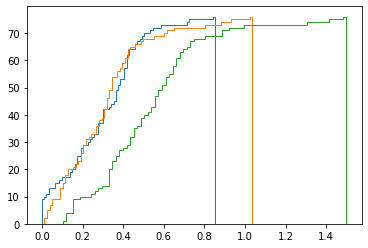

In [4]:
plt.hist([losstrackerSIX[i][0][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step")
plt.hist([losstrackerSIX[i][0][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step")
plt.hist([losstrackerSIX[i][0][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step")

(array([ 0.,  0.,  0.,  0.,  4.,  4.,  9., 10., 10., 10., 12., 13., 14.,
        20., 25., 27., 29., 32., 36., 38., 40., 43., 47., 51., 54., 58.,
        60., 63., 65., 68., 68., 68., 69., 69., 69., 70., 71., 72., 72.,
        72., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
        74., 74., 74., 74., 74., 75., 75., 75., 76., 76., 76., 76., 76.,
        76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76.,
        76., 76.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
        1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
        1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
        1.575, 1.6  , 1.625, 1.65 , 1.675, 1.

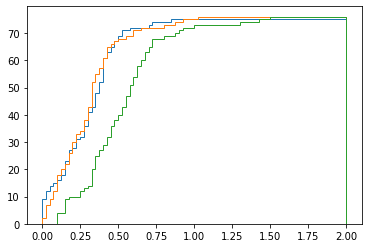

In [5]:
plt.hist([losstrackerSIX[i][0][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))
plt.hist([losstrackerSIX[i][0][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))
plt.hist([losstrackerSIX[i][0][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))

(array([ 7., 10., 15., 19., 23., 29., 31., 34., 36., 39., 43., 44., 45.,
        46., 51., 55., 58., 58., 59., 63., 65., 65., 65., 66., 66., 66.,
        66., 66., 66., 66., 66., 66., 69., 69., 69., 70., 70., 70., 70.,
        70., 70., 70., 71., 71., 71., 71., 72., 72., 72., 72., 72., 72.,
        72., 72., 72., 72., 72., 72., 72., 72., 72., 72., 73., 73., 73.,
        73., 73., 74., 74., 74., 74., 74., 74., 74., 74., 74., 74., 74.,
        74., 76.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
        1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
        1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
        1.575, 1.6  , 1.625, 1.65 , 1.675, 1.

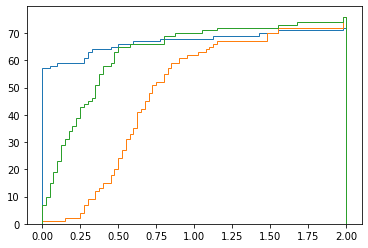

In [6]:
plt.hist([losstrackerSIX[i][3][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))
plt.hist([losstrackerSIX[i][3][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))
plt.hist([losstrackerSIX[i][3][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))

(array([ 0.,  0.,  0.,  0.,  4.,  4.,  9., 10., 10., 10., 12., 13., 14.,
        20., 25., 27., 29., 32., 36., 38., 40., 43., 47., 51., 54., 58.,
        60., 63., 65., 68., 68., 68., 69., 69., 69., 70., 71., 72., 72.,
        72., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73., 73.,
        74., 74., 74., 74., 74., 75., 75., 75., 76., 76., 76., 76., 76.,
        76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76.,
        76., 76.]),
 array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
        0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
        0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
        0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
        1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
        1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
        1.575, 1.6  , 1.625, 1.65 , 1.675, 1.

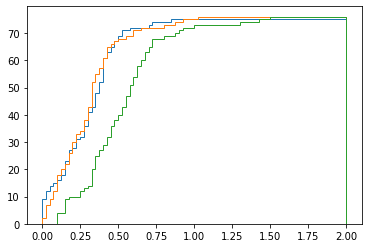

In [7]:
plt.hist([losstrackerSIXneg[i][0][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))
plt.hist([losstrackerSIXneg[i][0][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))
plt.hist([losstrackerSIXneg[i][0][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2))

(array([ 6.,  9., 10., 10., 10., 11., 13., 15., 17., 18., 18., 22., 24.,
        24., 25., 26., 29., 31., 33., 33., 34., 34., 34., 35., 37., 37.,
        38., 39., 40., 40., 40., 42., 42., 42., 42., 43., 46., 47., 47.,
        49., 54., 59., 62., 63., 63., 63., 63., 64., 64., 65., 65., 66.,
        66., 66., 66., 68., 69., 71., 72., 72., 72., 73., 74., 74., 75.,
        76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76., 76.,
        76., 76.]),
 array([-2.  , -1.95, -1.9 , -1.85, -1.8 , -1.75, -1.7 , -1.65, -1.6 ,
        -1.55, -1.5 , -1.45, -1.4 , -1.35, -1.3 , -1.25, -1.2 , -1.15,
        -1.1 , -1.05, -1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 ,
        -0.65, -0.6 , -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25,
        -0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
         0.25,  0.3 ,  0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,
         0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,
         1.15,  1.2 ,  1.25,  1.3 ,  1.35,  1

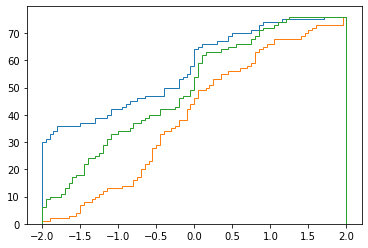

In [8]:
plt.hist([losstrackerSIXneg[i][3][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(-2,2))
plt.hist([losstrackerSIXneg[i][3][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(-2,2))
plt.hist([losstrackerSIXneg[i][3][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(-2,2))

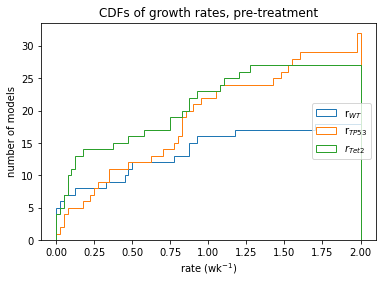

In [9]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIXneg[i][3][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
ax.hist([losstrackerSIXneg[i][3][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{TP53}$")
ax.hist([losstrackerSIXneg[i][3][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, pre-treatment")
ax.legend(loc="center right")

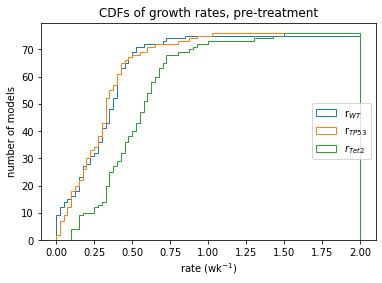

In [10]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIXneg[i][0][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
ax.hist([losstrackerSIXneg[i][0][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{TP53}$")
ax.hist([losstrackerSIXneg[i][0][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, pre-treatment")
ax.legend(loc="center right")

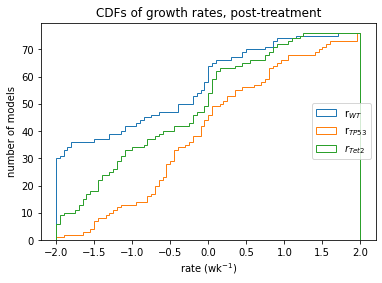

In [11]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIXneg[i][3][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(-2,2), label="r$_{WT}$")
ax.hist([losstrackerSIXneg[i][3][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(-2,2), label="r$_{TP53}$")
ax.hist([losstrackerSIXneg[i][3][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(-2,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, post-treatment")
ax.legend(loc="center right")

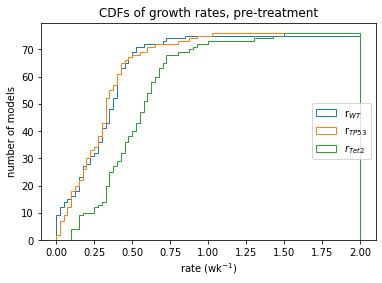

In [12]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIX[i][0][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
ax.hist([losstrackerSIX[i][0][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{TP53}$")
ax.hist([losstrackerSIX[i][0][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, pre-treatment")
ax.legend(loc="center right")

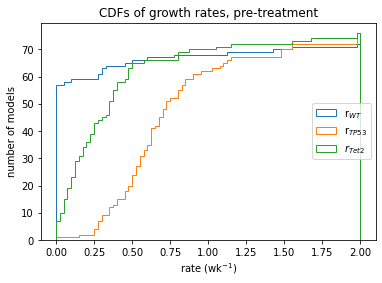

In [13]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIX[i][3][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
ax.hist([losstrackerSIX[i][3][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{TP53}$")
ax.hist([losstrackerSIX[i][3][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, pre-treatment")
ax.legend(loc="center right")

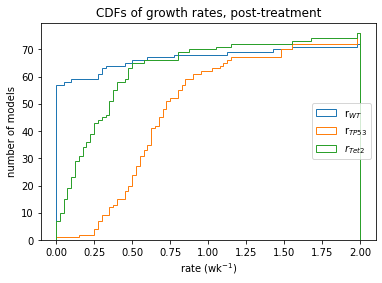

In [14]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIX[i][3][0] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
ax.hist([losstrackerSIX[i][3][1] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="r$_{TP53}$")
ax.hist([losstrackerSIX[i][3][2] for i in range(len(losstrackerSIX))], cumulative=True, bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, post-treatment")
ax.legend(loc="center right")

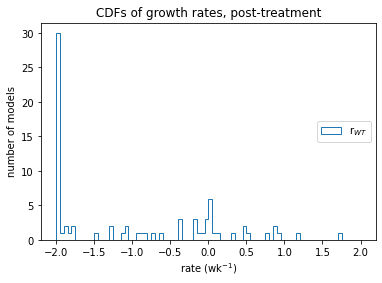

In [15]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

ax.hist([losstrackerSIXneg[i][3][0] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(-2,2), label="r$_{WT}$")
#ax.hist([losstrackerSIX[i][3][1] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(0,2), label="r$_{TP53}$")
#ax.hist([losstrackerSIX[i][3][2] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, post-treatment")
ax.legend(loc="center right")

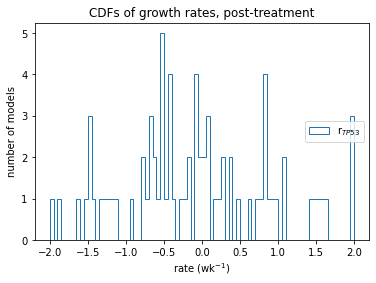

In [16]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

#ax.hist([losstrackerSIXneg[i][3][0] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
ax.hist([losstrackerSIXneg[i][3][1] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(-2,2), label="r$_{TP53}$")
#ax.hist([losstrackerSIX[i][3][2] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(0,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, post-treatment")
ax.legend(loc="center right")

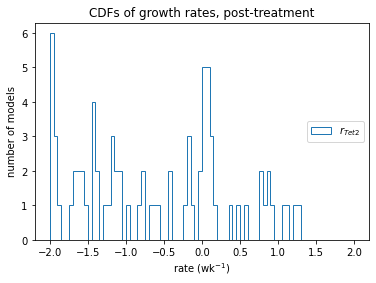

In [17]:
fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

#ax.hist([losstrackerSIXneg[i][3][0] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(0,2), label="r$_{WT}$")
#ax.hist([losstrackerSIXneg[i][3][1] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(-2,2), label="r$_{TP53}$")
ax.hist([losstrackerSIXneg[i][3][2] for i in range(len(losstrackerSIX))], bins=80, histtype="step", range=(-2,2), label="$r_{Tet2}$")
ax.set(xlabel="rate (wk$^{-1}$)", ylabel="number of models", title="CDFs of growth rates, post-treatment")
ax.legend(loc="center right")

[Text(0.5, 0, 'time(wks)'), Text(0, 0.5, 'cells')]

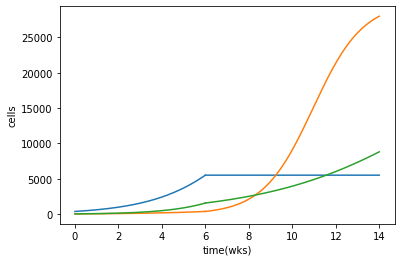

In [18]:
testvis = losstrackerSIX[3]

rates1 = testvis[0]
rates2 = testvis[3]
Amat1 = testvis[1]
Amat2 = testvis[4]

part1 = odeint(LVnprime, [400, 50, 50], np.linspace(0, 6, 5000), args=(rates1, Amat1))
part2 = odeint(LVnprime, part1[-1], np.linspace(6, 14, 9000), args=(rates2, Amat2))

fig = plt.figure(num=1, clear=True)
ax = fig.add_subplot(1,1,1)

#points = np.concatenate(part1[:,0], part2[:,0])
ax.plot(np.linspace(0,6,5000), part1[:,0], c="tab:blue")
ax.plot(np.linspace(6,14,9000), part2[:,0], c="tab:blue")

ax.plot(np.linspace(0,6,5000), part1[:,1], c="tab:orange")
ax.plot(np.linspace(6,14,9000), part2[:,1], c="tab:orange")

ax.plot(np.linspace(0,6,5000), part1[:,2], c="tab:green")
ax.plot(np.linspace(6,14,9000), part2[:,2], c="tab:green")

ax.set(xlabel="time(wks)", ylabel="cells")

In [20]:
keylist = list(treatdict.keys())

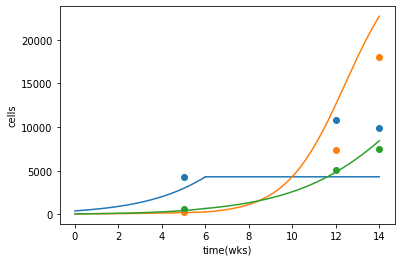

In [22]:
for i in range(10):
    testvis = losstrackerSIX[i]

    rates1 = testvis[0]
    rates2 = testvis[3]
    Amat1 = testvis[1]
    Amat2 = testvis[4]

    part1 = odeint(LVnprime, [400, 50, 50], np.linspace(0, 6, 5000), args=(rates1, Amat1))
    part2 = odeint(LVnprime, part1[-1], np.linspace(6, 14, 9000), args=(rates2, Amat2))

    fig = plt.figure(num=1, clear=True)
    ax = fig.add_subplot(1,1,1)

    # Trajectories
    ax.plot(np.linspace(0,6,5000), part1[:,0], c="tab:blue", label="WT")
    ax.plot(np.linspace(6,14,9000), part2[:,0], c="tab:blue")

    ax.plot(np.linspace(0,6,5000), part1[:,1], c="tab:orange", label="TP53")
    ax.plot(np.linspace(6,14,9000), part2[:,1], c="tab:orange")

    ax.plot(np.linspace(0,6,5000), part1[:,2], c="tab:green", label="Tet2")
    ax.plot(np.linspace(6,14,9000), part2[:,2], c="tab:green")

    # Data
    chdatapt = treatdict[keylist[i]]
    for datapt in chdatapt.data:
        pops = sum(np.concatenate((part1,part2), axis=0)[datapt.week*1000-1])
        ax.scatter(datapt.week, pops/100*datapt.probs[0], c="tab:blue")
        ax.scatter(datapt.week, pops/100*datapt.probs[1], c="tab:orange")
        ax.scatter(datapt.week, pops/100*datapt.probs[2], c="tab:green")

    ax.set(xlabel="time(wks)", ylabel="cells")

    fig.savefig("plots/2phase/model_{}.jpeg".format(keylist[i]))

In [ ]:
for i in range(10):
    testvis = losstrackerSIXneg[i]

    rates1 = testvis[0]
    rates2 = testvis[3]
    Amat1 = testvis[1]
    Amat2 = testvis[4]

    part1 = odeint(LVnprime, [400, 50, 50], np.linspace(0, 6, 6000), args=(rates1, Amat1))
    part2 = odeint(LVnprime, part1[-1], np.linspace(6, 14, 8000), args=(rates2, Amat2))

    fig = plt.figure(num=1, clear=True)
    ax = fig.add_subplot(1,1,1)

    # Trajectories
    ax.plot(np.linspace(0,6,5000), part1[:,0], c="tab:blue", label="WT")
    ax.plot(np.linspace(6,14,9000), part2[:,0], c="tab:blue")

    ax.plot(np.linspace(0,6,5000), part1[:,1], c="tab:orange", label="TP53")
    ax.plot(np.linspace(6,14,9000), part2[:,1], c="tab:orange")

    ax.plot(np.linspace(0,6,5000), part1[:,2], c="tab:green", label="Tet2")
    ax.plot(np.linspace(6,14,9000), part2[:,2], c="tab:green")

    # Data
    chdatapt = treatdict[keylist[i]]
    for datapt in chdatapt.data:
        pops = sum(np.concatenate((part1,part2), axis=0)[datapt.week*1000-1])
        ax.scatter(datapt.week, pops/100*datapt.probs[0], c="tab:blue")
        ax.scatter(datapt.week, pops/100*datapt.probs[1], c="tab:orange")
        ax.scatter(datapt.week, pops/100*datapt.probs[2], c="tab:green")

    ax.set(xlabel="time(wks)", ylabel="cells")

    fig.savefig("plots/2phase/model_{}_neg.jpeg".format(keylist[i]))